# Assignment 2

# 1: Word Classification

## 1.1: Evaluation Metrics

In [1]:
from collections import defaultdict
import numpy as np
import gzip
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#### Q1.1 Evaluation Metrics ####

## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

## Calculates the precision of the predicted labels

def get_precision(y_pred, y_true):
    tp = 0
    fp = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y_true[i] == 1:
            tp += 1
        elif y_pred[i] == 1 and y_true[i] == 0:
            fp +=1
    return tp/(tp+fp)
    
## Calculates the recall of the predicted labels
def get_recall(y_pred, y_true):
    tp = 0
    fn = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y_true[i] == 1:
            tp += 1
        elif y_pred[i] == 0 and y_true[i] == 1:
            fn += 1
    return tp/(tp+fn)

## Calculates the f-score of the predicted labels
def get_fscore(y_pred, y_true):
    pre = get_precision(y_pred, y_true)
    rec = get_recall(y_pred, y_true)
    return 2*(pre*rec)/(pre+rec) # harmonic averasge of precision and recall measures

def get_all_metrics(y_pred, y_true):
    return [get_precision(y_pred, y_true), get_recall(y_pred, y_true), get_fscore(y_pred, y_true)]

def test_predictions(y_pred, y_true):
    print("precision is {}".format(get_precision(y_pred, y_true)))
    print("recall is {}".format(get_recall(y_pred, y_true)))
    print("fscore is {}".format(get_fscore(y_pred, y_true)))

In [2]:
# sanity check 1.1
pred_labels = [1,0,1,0,1]
true_labels = [1,1,1,1,1]

We expect to get precision of 100%, recall of 60%, and fscore 75%

In [3]:
test_predictions(pred_labels, true_labels)

precision is 1.0
recall is 0.6
fscore is 0.7499999999999999


In [4]:
pred_labels = [1,1,1,1,1]
true_labels = [1,0,1,0,1]

We expect to get precision of 60%, recall of 100%, and fscore 75%

In [5]:
test_predictions(pred_labels, true_labels)

precision is 0.6
recall is 1.0
fscore is 0.7499999999999999


We expect to get 100% score on 1.1  :-)

## 1.2: Baselines

In [6]:
## Loads in the words and labels of one of the datasets
def load_file(data_file):
    words = []
    labels = []   
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

### 1.2.1: Majority Class Baseline

In [7]:
### 1.2.1: A very simple baseline

## Labels every word complex
def all_complex(data_file):
    words, labels = load_file(data_file)
    return get_all_metrics([1]*len(labels), labels)

Of course, we should get perfect recall. Precision and fscore which is affected by the precision, are dependent on the number of complex (label '1') words in the dataset. In fact, the precision will tell us the percentage of 'complex' words in the data.

In [8]:
all_complex("../data/complex_words_training.txt")

[0.43275, 1.0, 0.604083057058105]

In [9]:
all_complex("../data/complex_words_development.txt")

[0.418, 1.0, 0.5895627644569816]

As expected, perfect accuracy. Training dataset has 43% complex words, and development set only 41%. As it happens, our classifier isn't actually 'magority classfier'. If we would choose to predict '0' for all the words, we will improve on both training and development sets.

### 1.2.2: Word Length Baseline

We'll try to find the word length threshold. We expect to find such a threshold, due to our prior knowledge of the language - we know that, in general, longer words are less known and more 'complex'. This is probably because the way a langauge is evolved: at first, people took short words to signal meanings which were commonly used, as it is makes communication shorter and simpler. Derivations, inflections and other greens came later on. Therefore, we expect that at some word length and above, (almost) every word will be classified as 'complex'. This is the proof that there is a threshold and it isn't a monotonic function.

In [10]:
def word_length_classifier(file, length):
    words, labels = load_file(file)
    y_pred = [1 if len(w) >= length else 0 for w in words]               
    return get_all_metrics(y_pred, labels)

## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
## Also, draws a graph for recall X precision for the training data
def word_length_threshold(training_file, development_file):
    threshold = -1
    best_fscore = 0.0
    best_training_peformance = []
    xs = []
    ys = []
    for word_length in range(20):  # Assuming by prior knowledge of English, 
                                    # that the threshold must be in that range
        training_performance = word_length_classifier(training_file, word_length)
        if best_fscore < training_performance[2]:
            best_fscore = training_performance[2]
            threshold = word_length
            best_training_peformance = training_performance
        xs.append(training_performance[1])
        ys.append(training_performance[0])
    
    plt.plot(xs, ys)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('percision and recall as the word length reduces')
    plt.show()
    round_xs = [round(x,2) for x in xs]
    round_ys = [round(y,2) for y in ys]
    print ("recall:\n{}\nprecision: \n{}".format(round_xs, round_ys))
    print ("Threshold is {}".format(threshold))
    
    development_performance = word_length_classifier(development_file, threshold)

    return best_training_peformance, development_performance

Since we consider all relevant word length range, we should expect the following: clearly, for length of 0, the classifier labels all words with '1', and consequently equals the 'majority classifier'. Actually, since we expect words of length 1 and 2 to be all simple, the appropriate calssifiers are also 'majority classifiers'. We would expect them to have perfect recall and 43% precision, according the results we got above. On the other side of the scale, we would expect to get very poor recall for word length of 15-19, since these lengths implies all labels to be '0' and no true prediction is made. The recall should be monotonically decreasing with the increase of word length, due to the fact that we're 'hitting' less '1's or 'complex' words out of the total '1's. Precision should have a peak where the tradeoff between being cautious [=predicting '1's only when we're sure, i.e. for long words] and being reckless [=predicting too many '1's, even for very short words] is optimal.

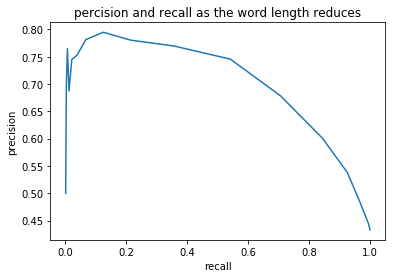

recall:
[1.0, 1.0, 1.0, 1.0, 0.99, 0.97, 0.93, 0.84, 0.71, 0.54, 0.36, 0.22, 0.13, 0.07, 0.04, 0.02, 0.01, 0.01, 0.0, 0.0]
precision: 
[0.43, 0.43, 0.43, 0.43, 0.44, 0.48, 0.54, 0.6, 0.68, 0.75, 0.77, 0.78, 0.79, 0.78, 0.75, 0.75, 0.69, 0.76, 0.7, 0.5]
Threshold is 7
For the threshold [precision, recall, f_score]:
 train - 0.601 0.844 0.702
 dev - 0.605 0.866 0.713


In [11]:
best_train_perf, dev_perf = word_length_threshold("../data/complex_words_training.txt", "../data/complex_words_development.txt")
print ("For the threshold [precision, recall, f_score]:\n train - {0:.3f} {1:.3f} {2:.3f}\n dev - {3:.3f} {4:.3f} {5:.3f}"\
       .format(best_train_perf[0], best_train_perf[1], best_train_perf[2], dev_perf[0], dev_perf[1], dev_perf[2]))

In general, our predictions were correct. The minor decrease in the left part of the graph, is probably caused by a defection in the data: one of the longer words groups (lenght of 16) had relatively few complex words in it, and the precision declined momentarily.

### 1.2.3: Word frequency thresholding

In [12]:
## Loads Google NGram counts
def load_ngram_counts(ngram_counts_file): 
   counts = defaultdict(int) 
   with gzip.open(ngram_counts_file, 'rt', encoding="utf8") as f: 
       for line in f:
           token, count = line.strip().split('\t') 
           if token[0].islower(): 
               counts[token] = int(count) 
   return counts

Next, we classify the complexity of words according their used frequency. The 'crazy know all' Google collected such information, and we use a sample of more than 8 million words with their appropriate frequency (probably, the number of times each appeared in a huge text corpus). We assume that if a word is frequent, it implies that many people use it, and therefore know it and regard them as 'readable' for other people as well. In short, many people treat this words as 'simple' to some extent. In fact, in some way, it extends hugely our data and development sets (although, without actual labels).
We expect to see similar results as in the word length threshold: recall will be perfect above a specific chosen frequency, since we will label everything as complex (or at least, everthing which is only a little complex and above, which, in practice, will be all the words we are looking at). Since 'The' appears around 50 billion times (in all it's forms: 'the', 'The', 'THE') in the Google corpus, it seems rational to think that the best threshold will be under 250 million (because of the huge decrease in the frequency function). We'll look for it in jumps of 10 millions.

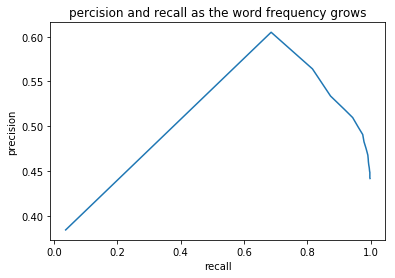

recall:
[0.04, 0.69, 0.82, 0.87, 0.92, 0.94, 0.96, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: 
[0.38, 0.6, 0.56, 0.53, 0.52, 0.51, 0.5, 0.49, 0.48, 0.48, 0.47, 0.47, 0.46, 0.46, 0.46, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.44, 0.44, 0.44]
Threshold is 20000000
For the threshold [precision, recall, f_score]:
 train - 0.564 0.816 0.667
 dev - 0.556 0.844 0.670


In [13]:
def word_frequency_classifier(file, freq):
    global counts
    words, labels = load_file(file)
    y_pred = [1 if counts[w] <= freq else 0 for w in words]
    return get_all_metrics(y_pred, labels)

# Finds the best frequency threshold by f-score, and uses this threshold to
## classify the training and development set
def word_frequency_threshold(training_file, development_file, counts):
    threshold = -1
    best_fscore = 0.0
    best_training_peformance = []
    xs = []
    ys = []
    for word_freq in range(0, 250000000, 10000000):
        training_performance = word_frequency_classifier(training_file, word_freq)
        if best_fscore < training_performance[2]:
            best_fscore = training_performance[2]
            threshold = word_freq
            best_training_peformance = training_performance
        xs.append(training_performance[1])
        ys.append(training_performance[0])
    
    plt.plot(xs, ys)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('percision and recall as the word frequency grows')
    plt.show()
    round_xs = [round(x,2) for x in xs]
    round_ys = [round(y,2) for y in ys]
    print ("recall:\n{}\nprecision: \n{}".format(round_xs, round_ys))
    print ("Threshold is {}".format(threshold))
    
    development_performance = word_frequency_classifier(development_file, threshold)

    return best_training_peformance, development_performance

counts = load_ngram_counts('../data/ngram_counts.txt.gz')
best_train_perf, dev_perf = word_frequency_threshold("../data/complex_words_training.txt",\
                                                     "../data/complex_words_development.txt", counts)
print ("For the threshold [precision, recall, f_score]:\n train - {0:.3f} {1:.3f} {2:.3f}\n dev - {3:.3f} {4:.3f} {5:.3f}"\
       .format(best_train_perf[0], best_train_perf[1], best_train_perf[2], dev_perf[0], dev_perf[1], dev_perf[2]))

Although the function has the predicted shape, the fine straight line on half the graph seems a little shady. Closer look reveals, that there's a huge jump in recall between word_freq of 0 to 10000000, which arouses suspicion that our search gap was too large. We'll to refine our search.
Note, that for word freq of 0, we didn't get 0 recall, although we label all the words as 'simple', unless their frequency is 0. That would mean Google didn't see them. It seemed a little weird at first, but after the following check, we had to accept that some of the 'complex' words weren't seen by Google, and therefore are probably not real words.

In [14]:
words, _ = load_file("../data/complex_words_training.txt")
counter = 0
for w in words:
    if counts[w] == 0:
        counter+=1
print ("Number of words from the training set that Google didn't see is {}".format(counter))

Number of words from the training set that Google didn't see is 164


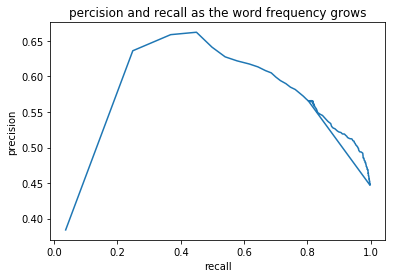

Threshold is 19900000
For the threshold [precision, recall, f_score]:
 train - 0.566 0.816 0.668
 dev - 0.557 0.844 0.671


In [15]:
def word_frequency_threshold_refined(training_file, development_file, counts):
    threshold = -1
    best_fscore = 0.0
    best_training_peformance = []
    xs = []
    ys = []
    upper_bound = 200000000
    lower_bound = 0
    for gap in range(6, 2, -1):
        for word_freq in range(lower_bound, upper_bound, 10**gap):
            training_performance = word_frequency_classifier(training_file, word_freq)
            if best_fscore < training_performance[2]:
                best_fscore = training_performance[2]
                threshold = word_freq
                best_training_peformance = training_performance
            xs.append(training_performance[1])
            ys.append(training_performance[0])
        lower_bound = threshold - 10**gap
        upper_bound = threshold + 10**gap
    
    plt.plot(xs, ys)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('percision and recall as the word frequency grows')
    plt.show()
    print ("Threshold is {}".format(threshold))
    
    development_performance = word_frequency_classifier(development_file, threshold)

    return best_training_peformance, development_performance

counts = load_ngram_counts('../data/ngram_counts.txt.gz')
best_train_perf, dev_perf = word_frequency_threshold_refined("../data/complex_words_training.txt",\
                                                     "../data/complex_words_development.txt", counts)
print ("For the threshold [precision, recall, f_score]:\n train - {0:.3f} {1:.3f} {2:.3f}\n dev - {3:.3f} {4:.3f} {5:.3f}"\
       .format(best_train_perf[0], best_train_perf[1], best_train_perf[2], dev_perf[0], dev_perf[1], dev_perf[2]))

It seems that our former search was pretty good. The straight line remained since it's not where the refinement took place.

Surprisingly, the word lengths classifier achieved better results than the word frequencies classifier. Looks that the comment above about how this frequencies are very close to indicators about word complexity didn't stand in reality.
Note: the upper line in the right side of the function is caused by the many dots we get in the area of the refinement. 

## 1.3 Classifiers

### 1.3.1: Naive Bayes classification

In [16]:
def naive_bayes(training_file, development_file, counts):
    twords, tlabels = load_file(training_file)
    word_lengths = [len(w) for w in twords]
    word_counts = [counts[w] for w in twords]
    lmean, lsd = get_list_mean_sd(word_lengths)
    cmean, csd = get_list_mean_sd(word_counts)

    # training the model
    X_train=[((len(w)-lmean)/lsd, (counts[w]-cmean)/csd) for w in twords]
    clf = GaussianNB()
    clf.fit(X_train, tlabels)
    
    dwords, dlabels = load_file(development_file)
    X_dev=[((len(w)-lmean)/lsd, (counts[w]-cmean)/csd) for w in dwords]
    
    # prediction
    training_performance = get_all_metrics(clf.predict(X_train), tlabels)
    development_performance = get_all_metrics(clf.predict(X_dev), dlabels)
    return training_performance, development_performance

def get_list_mean_sd(lst):
    return np.average(lst), np.std(lst)

if __name__ == "__main__":
    training_file = "../data/complex_words_training.txt"
    development_file = "../data/complex_words_development.txt"
    
    counts = load_ngram_counts('../data/ngram_counts.txt.gz')
    
    print(naive_bayes(training_file, development_file, counts))


([0.4950379451255108, 0.9797804737146159, 0.6577467519875897], [0.46929316338354576, 0.9688995215311005, 0.6323185011709602])


## 1.4: Ambiguity

We'll simply try to find words which were labeled both 'simple' and 'complex', and the reason to the difference is likely to be the different contexts, which give the word a different meaning.

In [17]:
def load_file_with_sentences(data_file):
    words = []
    labels = []
    sentences = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
                sentences.append(line_split[3])
            i += 1
    return words, labels, sentences

def context_sensitive(file):
    words, labels, sentences = load_file_with_sentences(file)
    complex_sentences = []
    simple_sentences = []
    ambigious_words = []
    for i in range(len(words)):
        for j in range(i+1, len(words)):
            if words[i] == words[j] and not labels[i] == labels[j]:
                ambigious_words.append(words[i])
                if labels[i] == 1:
                    complex_sentences.append(sentences[i])
                    simple_sentences.append(sentences[j])
                else:
                    complex_sentences.append(sentences[j])
                    simple_sentences.append(sentences[i])
    return ambigious_words, simple_sentences, complex_sentences

w, s, c = context_sensitive("../data/complex_words_training.txt")
for i in range(10):
    print('Word: ' + w[i])
    print('Simple Context: ' + s[i])
    print('Complex Context: ' + c[i] + '\n')

Word: campaign
Simple Context: `` Given the way the meeting transpired , '' Ray Halbritter , an Oneida representative and leader of the `` Change the Mascot Campaign , '' said Wednesday , `` it became somewhat evident they were defending the continued use of the name .
Complex Context: The campaign around the Maine Bear Hunting Ban Initiative , which will appear on the ballot as Question 1 , has shed light on Maine 's unique status in the wildlife world .

Word: element
Simple Context: Element 118 , for example , is the heaviest element to date , with 118 protons alongside 176 neutrons .
Complex Context: Arturo Sanchez is in his element .

Word: inspired
Simple Context: Inspired by their courage , demonstrators across the South adopted their `` jail not bail '' tactic and filled jail cells .
Complex Context: Miguel Castañeda started Tech Connect in 2009 , inspired by a similar program in San Francisco .

Word: district
Simple Context: Before the jurors began their deliberations , Distr

We can see that our approach was correct in its core - in the second and seventh sentences (words 'element' and 'sprouts', appropriately), the observed word has a different meaning. It's unclear why the other words got different labels: a possible reason might belong with the experiment process - the annotators had to point at 'complex' words, and in some sentences, even the most 'complex' words were simple.

# 2: Document Classification

## 2.1: Reuters Dataset

The next cell is a copy of the code intended for initializing the dataset (which we were referred to in the homework page). Can be ignored.

In [18]:
# Authors: Eustache Diemert <eustache@diemert.fr>
#          @FedericoV <https://github.com/FedericoV/>
# License: BSD 3 clause

from __future__ import print_function
from glob import glob
import itertools
import os.path
import re
import tarfile
import time
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.externals.six.moves import html_parser
from sklearn.externals.six.moves.urllib.request import urlretrieve
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB


def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()
class ReutersParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                sys.stdout.write(
                    '\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb))

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path,
                    reporthook=progress)
        if _not_in_sphinx():
            sys.stdout.write('\r')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc

## 2.1.1 + 2.1.2

We got the required information with slight manipulations of the code we were referred to.

In [19]:
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18,
                               alternate_sign=False)


# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents()

# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(max_iter=5),
    'Perceptron': Perceptron(tol=1e-3),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(tol=1e-3),
}

categories_dict = {}
def get_minibatch(doc_iter, size, pos_class=''):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    
    data = []
    for doc in itertools.islice(doc_iter, size):
        for topic in doc['topics']:
            categories_dict[topic] = (categories_dict[topic] + 1) if topic in categories_dict else 1
        if doc['topics']:
            data.append((u'{title}\n\n{body}'.format(**doc), pos_class in doc['topics']))
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)

# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.
minibatch_size = 1000

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

num_docs = 0
total_chars = 0
total_words = 0
num_docs = 0
# Main loop : iterate on mini-batches of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    X_train = vectorizer.transform(X_train_text)
    num_chars = 0
    num_words = 0
    for line in X_train_text:
            words = line.split()
            num_words += len(words)
            for w in words:
                num_chars += len(w)
    total_chars += num_chars
    total_words += num_words
    num_docs += X_train.shape[0]

print ("Number of documents is {}".format(num_docs))
print ("Number of categories is {}".format(len(categories_dict)))

categories_values = list(categories_dict.values())
categories_mean, categories_sd = get_list_mean_sd(categories_values)

print ("Mean of documents per category is {}, standard deviation is {}, min is {}, max is {}". 
      format(round(categories_mean, 2), round(categories_sd, 2), min(categories_dict.values()), max(categories_dict.values())))

print ("Number of words is {}".format(total_words))
print ("Number of characters is {}".format(total_chars))


Number of documents is 19716
Number of categories is 445
Mean of documents per category is 89.87, standard deviation is 643.93, min is 1, max is 12542
Number of words is 2638722
Number of characters is 13343784


### 2.1.3

The classifiers use the method partial fit in order to learn the tranining in chuncks - if we don't want to hold all the dataset in the RAM or maybe we can't do it since we get the training set as a stream of data, we want to be able to learn from the accessible data, and later on to adjust our classifier according to received data. In that case, we use a classifier which has this possibility. For example, the SGD classifier builds a function of the desired params of the classifier we're looking for, and then try to minimize it according to the samples it gets, while it sample from the dataset stochastically, and adjusts the result according the specific sample. It's clear that it might take the samples from a stream. This is also useful in case that newer data is more relevant than old data, and then it's possible to control the adjusment rate.

### 2.1.4

The hashing vectorizer takes a text document and converts it to a vector holding the counts of tokens in the text. It's being used under the assumption that there is a very small probability that 2 different samples will be converted to the same vector. Than the classifiers take the received vector as the sample to learn from (or predict on). It's important to acheive 'streaming classification' since there is no state computed during fit.

## 2.2: Spam Dataset

### 2.2.1

Following is the given notebook code. Can be ignored.

In [20]:
%matplotlib inline
import os
import sys
import numpy
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score

def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

NEWLINE = '\n'
HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('../data/spam/spam',        SPAM),
    ('../data/spam/easy_ham',    HAM),
    ('../data/spam/hard_ham',    HAM),
    ('../data/spam/beck-s',      HAM),
    ('../data/spam/farmer-d',    HAM),
    ('../data/spam/kaminski-v',  HAM),
    ('../data/spam/kitchen-l',   HAM),
    ('../data/spam/lokay-m',     HAM),
    ('../data/spam/williams-w3', HAM),
    ('../data/spam/BG',          SPAM),
    ('../data/spam/GP',          SPAM),
    ('../data/spam/SH',          SPAM)
]

SKIP_FILES = {'cmds'}


def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(read_files(path)):
        if ((i+l) % 100 == 0):
            progress(i+l, 58910, 50)
        rows.append({'text': text, 'class': classification})
        index.append(file_name)
   
    data_frame = DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = DataFrame({'text': [], 'class': []})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame, sort=False)
        l += nrows
    data = data.reindex(numpy.random.permutation(data.index))
    return data

# This should take about 2 minutes
data=load_data()

Percent: [##################################################] 100%

In [21]:
def build_pipeline():
    pipeline = Pipeline([
        ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2))),
        ('classifier',         MultinomialNB())
    ])
    return pipeline

def train(data = None, n_folds = 6):
    if data is None:
        print("Loading data...")
        data = load_data()
        print("Data loaded")
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline()
    scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(data)):
        train_text = data.iloc[train_indices]['text'].values
        train_y = data.iloc[train_indices]['class'].values.astype(str)

        test_text = data.iloc[test_indices]['text'].values
        test_y = data.iloc[test_indices]['class'].values.astype(str)

        print("Training for fold %d" % i)
        pipeline.fit(train_text, train_y)
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)

        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=SPAM)
        scores.append(score)
        print("Score for %d: %2.2f" % (i, score))
        print("Confusion matrix for %d: " % i)
        print(confusion)

    print('Total emails classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
    return pipeline

In [22]:
pipeline = train(data)

Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.98
Confusion matrix for 0: 
[[3854   18]
 [ 267 5680]]
Training for fold 1
Testing for fold 1
Score for 1: 0.98
Confusion matrix for 1: 
[[ 7772    35]
 [  496 11335]]
Training for fold 2
Testing for fold 2
Score for 2: 0.98
Confusion matrix for 2: 
[[11711    50]
 [  741 16954]]
Training for fold 3
Testing for fold 3
Score for 3: 0.98
Confusion matrix for 3: 
[[15641    65]
 [  966 22602]]
Training for fold 4
Testing for fold 4
Score for 4: 0.98
Confusion matrix for 4: 
[[19501    74]
 [ 1201 28316]]
Training for fold 5
Testing for fold 5
Score for 5: 0.98
Confusion matrix for 5: 
[[23450    89]
 [ 1427 33944]]
Total emails classified: 58910
Score: 0.9781590913527961
Confusion matrix:
[[23450    89]
 [ 1427 33944]]


### 2.2.1

Obviously, we expect much more bigrams than unigrams.

In [23]:
feature_number = len(pipeline.get_params()['count_vectorizer'].get_feature_names())

In [24]:
bigrams_count = 0
for feature_name in pipeline.get_params()['count_vectorizer'].get_feature_names():
    if (' ' in feature_name):
        bigrams_count +=1

print ("Number of unigrams is {} and number of bigrams is {}".format(feature_number - bigrams_count, bigrams_count))

Number of unigrams is 615615 and number of bigrams is 2949080


### 2.2.2

In [25]:
cv = CountVectorizer(ngram_range=(1, 2))

all_indices = range(0, len(data))

def print_50_freq_bi_uni(indices):

    text = data.iloc[indices]['text'].values
    y = data.iloc[indices]['class'].values.astype(str)
    vec = cv.fit(text, y)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq_sorted =sorted(words_freq, key = lambda x: x[1], reverse=True)
    unigrams_count = 0
    bigrams_count = 0
    unigrams = []
    bigrams = []
    for i in range(len(words_freq_sorted)):
        if ' ' in words_freq_sorted[i][0]:
            bigrams.append(words_freq_sorted[i][0])
            bigrams_count += 1
            if (bigrams_count == 50):
                break
        elif unigrams_count < 50:
            unigrams.append(words_freq_sorted[i][0])
            unigrams_count += 1
    print("50 most frequent unigrams are:\n{}\n".format(unigrams))
    print("50 most frequent bigrams are:\n{}\n".format(bigrams))


In [26]:
print_50_freq_bi_uni(all_indices)

50 most frequent unigrams are:
['font', '3d', 'the', 'br', 'td', 'to', 'and', 'nbsp', 'of', 'http', '20', 'size', 'tr', 'in', 'width', 'com', 'you', 'face', 'for', 'border', 'is', 'style', 'this', 'align', 'span', 'href', 'height', 'html', 'color', 'www', 'that', 'on', 'your', 'content', 'table', 'with', 'be', 'div', 'arial', 'it', 'from', 'we', 'or', 'center', 'img', 'as', 'enron', 'src', 'are', 'text']

50 most frequent bigrams are:
['nbsp nbsp', 'br br', 'font size', 'td tr', 'http www', 'font face', 'td td', 'tr td', '3d http', 'style 3d', 'font td', 'tr tr', 'href 3d', 'font font', 'of the', 'td width', 'color 3d', 'font color', 'img src', 'href http', 'in the', 'arial helvetica', 'width 3d', 'sans serif', 'face 3d', 'size 3d2', 'align center', 'content type', 'helvetica sans', 'bgcolor 3d', 'src http', '1px solid', 'gif width', 'font family', 'tr table', 'size 3d', 'face 3darial', 'br font', 'face 3dverdana', '3d font', 'src 3d', 'span style', 'text html', 'face arial', 'align 3d

At first glance it would seems very surprising that 'the' and the other most common words in english don't take all the first places. It's also surprising in second glance, but we need to remember that we are dealing with a lot of emails, which will explain how 'http' got to be in the top ten. Also, we are dealing with a lot of spam, which probably has different word frequencies, which might explain '3d' and 'size', for example. However, how 'font', 'br', 'td', and other non-words (and the weirdest 'nbsp nbsp' which is the most frequent bigram!) got to be so common, is a mystery. 

### 2.2.3

In [27]:
y = data.iloc[all_indices]['class'].values.astype(str)
print("Most frequent for spam:\n")
spam_indices = [idx for idx in all_indices if y[idx] == 'spam']
print_50_freq_bi_uni(spam_indices)

print("Most frequent for ham:\n")
ham_indices = [idx for idx in all_indices if y[idx] == 'ham']
print_50_freq_bi_uni(ham_indices)

Most frequent for spam:

50 most frequent unigrams are:
['font', '3d', 'br', 'td', 'nbsp', 'the', 'size', 'tr', 'to', '20', 'http', 'and', 'width', 'of', 'face', 'border', 'style', 'span', 'align', 'com', 'in', 'color', 'html', 'you', 'href', 'height', 'content', 'is', 'this', 'www', 'div', 'for', 'your', 'arial', 'table', 'center', 'text', 'img', 'class', 'body', 'src', 'strong', 'or', '3d2', '3d0', 'that', 'type', 'with', 'be', 'bgcolor']

50 most frequent bigrams are:
['nbsp nbsp', 'br br', 'font size', 'td tr', 'font face', 'td td', 'tr td', '3d http', 'style 3d', 'http www', 'font td', 'tr tr', 'href 3d', 'font font', 'color 3d', 'font color', 'td width', 'arial helvetica', 'width 3d', 'face 3d', 'size 3d2', 'sans serif', 'content type', 'align center', 'helvetica sans', '1px solid', 'href http', 'bgcolor 3d', 'font family', 'face 3darial', 'size 3d', 'face 3dverdana', '3d font', 'img src', 'of the', 'br font', 'span style', 'tr table', 'text html', 'align 3d', 'size 3d1', 'td ali

Now things look much better: in the 'ham' part, we see results of normal English, although email related. Probably, the spam wasn't what the 'people' call spam, such as advertisements, but it was constructed from pile of meaningless garbage.

### 2.2.4

We expect to get the following results: the best features will be those words that appear only in one of the classes 'spam' and 'ham' - we can be (almost) totally sure when classifying according to these features. Therefore, a possible output might be gibrish for the 'spam' features, since we don't expect to get meaningless words in real emails. In the other direction, a possible output for the best of 'ham' features might be very meaningful words, such as scientific words, which we don't expect to see in spam emails\SMSs.

The coef_ of the classifier holds the weights of the features for the classifiction text (after the training). Therefore, we need to take the indices of the highest and lowest 20 weights, and find the appropriate features.

In [28]:
feature_names = pipeline.get_params()['count_vectorizer'].get_feature_names()
top20 = np.argsort(pipeline.get_params()['classifier'].coef_[0])[-20:]
low20 = np.argsort(pipeline.get_params()['classifier'].coef_[0])[:20]

In [29]:
for idx in top20:
    print (feature_names[idx])
print("\n\n")
for idx in low20:
    print (feature_names[idx])

align
span
style
face
br br
width
of
nbsp nbsp
and
http
20
to
tr
size
the
nbsp
td
br
3d
font



imac ipod
has forward
has formally
has forgotten
has forfeited
has forced
has followed
has folded
has fm
has fluctuated
has flowed
has forwarded
has flourished
has flexmode
has fixed
has five
has firmly
has firm
has fired
has finite


### 2.2.5

In general, normalization is required for classifiers which are affected by the absolute values of the features, or by the relative differences between the features (there is also a speed improvement for some algorithms by normalization, but as it doesn't change the output, it's less relevant for the question). In the first group we can find regularized algorithms, and in the second group appear k-nearest neighbors, for example. Since irregularized naive bayes and regression algorithms don't fall in both categories, there shouldn't be any improvement by normalizing the extra feature to be in the same range as the others.

In general, adding 'good' features (i.e. features that we know by prior information that they are relevant) to the model should improve the learning unless there're too many features which leads to overfitting. In our case, there're so many features as it is (number of word types), that another feature shouldn't do much harm regarding overfitting. Since this we expect this feature to be more predictive then many of the word type features, we expect the learning algorithms to perform better.

### 2.2.6

In [30]:
from sklearn.base import TransformerMixin

class LengthTransformer(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [[len(datum)] for datum in X]

from sklearn.pipeline import FeatureUnion

def build_pipeline():
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2))),
            ('doc_length', LengthTransformer())
        ])),
        ('classifier',         MultinomialNB())
    ])
    return pipeline

def train(data = None, n_folds = 6):
    if data is None:
        print("Loading data...")
        data = load_data()
        print("Data loaded")
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline()
    scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(data)):
        train_text = data.iloc[train_indices]['text'].values
        train_y = data.iloc[train_indices]['class'].values.astype(str)

        test_text = data.iloc[test_indices]['text'].values
        test_y = data.iloc[test_indices]['class'].values.astype(str)

        print("Training for fold %d" % i)
        pipeline.fit(train_text, train_y)
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)

        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=SPAM)
        scores.append(score)
        print("Score for %d: %2.2f" % (i, score))
        print("Confusion matrix for %d: " % i)
        print(confusion)

    print('Total emails classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
    return pipeline

pipeline = train(data)

Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.98
Confusion matrix for 0: 
[[3850   22]
 [ 225 5722]]
Training for fold 1
Testing for fold 1
Score for 1: 0.98
Confusion matrix for 1: 
[[ 7766    41]
 [  435 11396]]
Training for fold 2
Testing for fold 2
Score for 2: 0.98
Confusion matrix for 2: 
[[11703    58]
 [  644 17051]]
Training for fold 3
Testing for fold 3
Score for 3: 0.98
Confusion matrix for 3: 
[[15625    81]
 [  839 22729]]
Training for fold 4
Testing for fold 4
Score for 4: 0.98
Confusion matrix for 4: 
[[19480    95]
 [ 1035 28482]]
Training for fold 5
Testing for fold 5
Score for 5: 0.98
Confusion matrix for 5: 
[[23423   116]
 [ 1227 34144]]
Total emails classified: 58910
Score: 0.9807132210394963
Confusion matrix:
[[23423   116]
 [ 1227 34144]]


Recall, that the fscore before the change was 0.9782823670397819, which means approximately 10% error reduction.

# 3: Named Entity Recognition

In this task we will try to tag words in a text as: PER, LOC, ORG, MISC and O for person name, location, organization and none of this, respectively. Each word can tagged as B-X for word that begins the X name, I-X for word that into X name and O for words that are not names at all. 
for this task we use conll2002 corpus.

## 3.1: Features

### 3.1.1: Feature Extraction

So, we will transform every word to dictionary of it's features. In the first try we wikk try this:
    - The word form (the string as it appears in the sentence)
    - The POS of the word (which is provided in the dataset)
    - ORT - a feature that captures the orthographic (letter) structure of the word. It can have any of the following values: number, contains-digit, contains-hyphen, capitalized, all-capitals, URL, punctuation, regular.
    - prefix1: first letter of the word
    - prefix2: first two letters of the word
    - prefix3: first three letters of the word
    - suffix1: last letter of the word
    - suffix2: last two letters of the word
    - suffix3: last three letters of the word


In [33]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
import nltk
nltk.download('conll2002')

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def features2vector(data_sent):
    features = [sent2features(sent) for sent in data_sent]
    f_feathures = [item for sent in features for item in sent]
    return f_feathures

def labels2vector(data_sent):
    labels = [sent2labels(sent) for sent in data_sent]
    f_labels = [item for sent in labels for item in sent]
    return f_labels

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = {
        'word form': word,
        'pos': postag,
        'ORT number': 1 if word.isdigit() else 0,
        'ORT contain number': 1 if hasNumbers(word) else 0,
        'ORT all-capitals': 1 if word.isupper() else 0,
        'ORT capitalized': 1 if word[:1].isupper() else 0,
        'ORT punctuation': 1 if (c in string.punctuation() for c in word) else 0,
        'preffix1': word[:1],
        'preffix2': word[:2],
        'preffix3': word[:3],
        'suffix1': word[-1:],
        'suffix2': word[-2:],
        'suffix3': word[-3:],
    }           
    return features

[nltk_data] Downloading package conll2002 to
[nltk_data]     /users/studs/bsc/2016/berendb/nltk_data...
[nltk_data]   Unzipping corpora/conll2002.zip.


In [34]:
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
dev_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))
sent2features(train_sents[0])[0]

{'word form': 'Melbourne',
 'pos': 'NP',
 'ORT number': 0,
 'ORT contain number': 0,
 'ORT all-capitals': 0,
 'ORT capitalized': 1,
 'ORT punctuation': 1,
 'preffix1': 'M',
 'preffix2': 'Me',
 'preffix3': 'Mel',
 'suffix1': 'e',
 'suffix2': 'ne',
 'suffix3': 'rne'}

This was an example for a transformed word. Every dictionary that present word, will be transformed into a vector that captures this features.

### 3.1.2: Train

In [35]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import pandas as pd

def train_model(Xtrain, Ytrain):
    clf = Pipeline([
    ('vectorizer', DictVectorizer(sparse=True)),
	('classifier', LogisticRegression())
    ])
    clf.fit(Xtrain, Ytrain)
    return clf

In [36]:
Xtrain = features2vector(train_sents)
Ytrain = labels2vector(train_sents)
clf = train_model(Xtrain, Ytrain)
Xtest = features2vector(dev_sents)
Ypred = clf.predict(Xtest)
Ytrue = labels2vector(dev_sents)
print(clf.score(Xtest, Ytrue))
print(metrics.classification_report(Ytrue, Ypred))


/users/studs/bsc/2016/berendb/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/users/studs/bsc/2016/berendb/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9441134806822813
              precision    recall  f1-score   support

       B-LOC       0.65      0.70      0.67      1084
      B-MISC       0.49      0.42      0.45       339
       B-ORG       0.76      0.82      0.79      1400
       B-PER       0.64      0.68      0.66       735
       I-LOC       0.51      0.19      0.27       325
      I-MISC       0.43      0.14      0.21       557
       I-ORG       0.56      0.27      0.37      1104
       I-PER       0.56      0.64      0.60       634
           O       0.98      1.00      0.99     45355

   micro avg       0.94      0.94      0.94     51533
   macro avg       0.62      0.54      0.56     51533
weighted avg       0.94      0.94      0.94     51533



In [37]:
print("confusion matrix:")
y_true = pd.Series(Ytrue)
y_pred = pd.Series(Ypred)
pd.crosstab(y_true, y_pred, rownames=['True Label'], colnames=['Predicted Label'], margins=True)

confusion matrix:


Predicted Label,B-LOC,B-MISC,B-ORG,B-PER,I-LOC,I-MISC,I-ORG,I-PER,O,All
True Label,,,,,,,,,,
B-LOC,763,4,125,43,15,13,20,43,58,1084
B-MISC,16,141,55,6,0,17,27,13,64,339
B-ORG,93,23,1147,43,2,1,30,29,32,1400
B-PER,52,4,21,503,10,4,12,117,12,735
I-LOC,54,7,22,24,61,1,28,29,99,325
I-MISC,33,19,29,24,4,77,71,25,275,557
I-ORG,128,66,68,27,14,49,301,52,399,1104
I-PER,34,3,9,102,14,11,30,405,26,634
O,9,18,28,9,0,6,23,7,45255,45355


The results seems pretty good by first look, but in second one you can see that the f-score of every tag except 'O', is not so high. The problem here is that 'O' tag capture most of the words, so even if it's predict everithing as 'O' the total  f-score will be pretty high.
Let's add some more features and see if there is improvement.

In [38]:
def word2extend_features(sent, i):
    feature = word2features(sent, i)
    word = sent[i][0]
    postag = sent[i][1]
    prev_word = ''
    prev_postag = ''
    next_word = ''
    next_postag = ''
    if i > 0:
        prev_word = sent[i-1][0]
        prev_postag = sent[i-1][1]
    if i < len(sent) - 1:
        next_word = sent[i+1][0]
        next_postag = sent[i+1][1]
    ext = {
        'has hyphen': 1 if '-' in word else 0,
        'place': i,
        'sent len': len(sent),
        'prev word': prev_word,
        'prev postag': prev_postag,
        'next word': next_word,
        'next postag': next_postag
    }
    feature.update(ext)
    return feature

In [39]:
def extends_features2vector(data_sent):
    features = [sent2extendsfeatures(sent) for sent in data_sent]
    f_feathures = [item for sent in features for item in sent]
    return f_feathures

def sent2extendsfeatures(sent):
    return [word2extend_features(sent, i) for i in range(len(sent))]


In [40]:
Xtrain = extends_features2vector(train_sents)
Ytrain = labels2vector(train_sents)
clf = train_model(Xtrain, Ytrain)
Xtest = extends_features2vector(dev_sents)
Ypred = clf.predict(Xtest)
Ytrue = labels2vector(dev_sents)
print(clf.score(Xtest, Ytrue))
print(metrics.classification_report(Ytrue, Ypred))

0.9588613121689015
              precision    recall  f1-score   support

       B-LOC       0.73      0.71      0.72      1084
      B-MISC       0.54      0.42      0.47       339
       B-ORG       0.78      0.83      0.81      1400
       B-PER       0.83      0.87      0.85       735
       I-LOC       0.72      0.39      0.50       325
      I-MISC       0.59      0.27      0.38       557
       I-ORG       0.74      0.52      0.61      1104
       I-PER       0.77      0.90      0.83       634
           O       0.98      1.00      0.99     45355

   micro avg       0.96      0.96      0.96     51533
   macro avg       0.74      0.66      0.68     51533
weighted avg       0.95      0.96      0.96     51533



In [41]:
print("confusion matrix:")
y_true = pd.Series(Ytrue)
y_pred = pd.Series(Ypred)
pd.crosstab(y_true, y_pred, rownames=['True Label'], colnames=['Predicted Label'], margins=True)

confusion matrix:


Predicted Label,B-LOC,B-MISC,B-ORG,B-PER,I-LOC,I-MISC,I-ORG,I-PER,O,All
True Label,,,,,,,,,,
B-LOC,768,6,132,44,14,7,33,19,61,1084
B-MISC,23,141,60,5,1,14,19,12,64,339
B-ORG,97,15,1168,48,1,8,22,19,22,1400
B-PER,24,3,19,643,2,2,7,23,12,735
I-LOC,29,4,11,7,126,10,40,28,70,325
I-MISC,20,28,22,6,12,153,65,11,240,557
I-ORG,81,50,51,4,15,41,579,53,230,1104
I-PER,9,2,1,9,2,6,14,570,21,634
O,8,14,28,8,3,17,8,4,45265,45355


All the results got better, some by far. Total fscore improved from 0.944 to 0.958 which is an error reduction of 25% approximately.

### 3.1.3: Illegal Tags Sequences

Our predictor predicts without optimizing sequence of tags, so there is a lot of illegal sequence in the prediction tags. We provide code that gets prediction of tags sequence and returns a table where the entry i,j represent the frequency of the mistake of kind j in type i. The mistake kinds of type X are: O-IX, IX-IY, BX-IY, IY-IX, BY-IX.

In [51]:
import numpy as np
def find_illegal_seq(Ypred, types):
    illegl = np.zeros((4,6))
    types_counter = np.zeros((len(types),), dtype=int)
    for t in types:
        for i in range(1, len(Ypred)):
            p = Ypred[i]
            if p[2:] == t:
                types_counter[types.index(t)]+=1
                if p[0] == 'I':
                    if Ypred[i-1] == 'O':
                        illegl[types.index(t)][0] += 1
                    elif not Ypred[i-1][2:] == t:
                        l = (3 if Ypred[i-1][0] == 'I'  else 4)
                        illegl[types.index(t)][l] += 1
                    if i < len(Ypred) and not (Ypred[i+1])[2:] == t:
                        illegl[types.index(t)][1] += 1
                elif p[0] == 'B':
                    if i < len(Ypred)-1 and not ((Ypred[i+1])[2:] == t):
                        illegl[types.index(t)][2] += 1
    
    for i in range(len(types)):
        for j in  range(5):
            illegl[i][j] = round(illegl[i][j]/types_counter[i], 2)
            
    return illegl

def print_illegal_matrix(illegal, types):
    print('Mistake type\tO-IX\tIX-IY\tBX-IY\tIY-IX\tBY-IX')
    print('Tag type')
    for i in range(len(types)):
        print(types[i]+'\t\t'+str(illegal[i][0])+'\t'+str(illegal[i][1])+'\t'+str(illegal[i][2])+'\t'+str(illegal[i][3])+'\t'+str(illegal[i][4]))
    

In [52]:
types = ['LOC', 'MISC', 'ORG', 'PER']
i = find_illegal_seq(Ypred, types)
print_illegal_matrix(i, types)

Mistake type	O-IX	IX-IY	BX-IY	IY-IX	BY-IX
Tag type
LOC		0.03	0.12	0.78	0.01	0.01
MISC		0.17	0.38	0.36	0.04	0.05
ORG		0.07	0.25	0.51	0.01	0.02
PER		0.07	0.42	0.19	0.01	0.02


As we can see, the major problems were when continuing, i.e. transitioning from BX or IX to IY. The explanation might be that the model is generally good with identifying the sequences of NER, including cases when the entity was composed from more than one word, but the similarities between the entities (Nouns, start with capital letters) caused mislabeling the sub-parts of the entity correctly.

##  3.2: Using Word Embeddings

Now we try to improve our NER task by adding word vector as extra features of the word. we treat every entry in the vector as new feature in the features of the word. In case that we can, we add the word vectors of the previous and next words, so we expect that the tags sequence will improve.

In [ ]:
import gensim
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors
vec_file_name = '../wiki.es.vec'
wordvectors = KeyedVectors.load_word2vec_format(vec_file_name)

In [45]:
def word2extend_features_with_wv(sent, i):
    feature = word2extend_features(sent, i)
    word = sent[i][0]
    try:
        wv =  wordvectors.wv[word]
        feature.update(wv2feature(wv))
    except:
        pass            
    if i > 0:
        prev_word = sent[i-1][0]
        try:
            pwv =  wordvectors.wv[prev_word]
            feature.update(wv2feature(pwv))
        except:
            pass
    if i < len(sent) - 1:
        next_word = sent[i+1][0]
        try:
            nwv =  wordvectors.wv[next_word]
            feature.update(wv2feature(nwv))
        except:
            pass
    return feature

def wv2feature(wv):
    f = {}
    for i in range(len(wv)):
        f_i = {
            'f'+str(i): wv[i]
        }
        f.update(f_i)
    return f

In [46]:
def extends_features2vector2(data_sent):
    features = [sent2extendsfeatures2(sent) for sent in data_sent]
    f_feathures = [item for sent in features for item in sent]
    return f_feathures

def sent2extendsfeatures2(sent):
    return [word2extend_features_with_wv(sent, i) for i in range(len(sent))]

In [47]:
Xtrain = extends_features2vector2(train_sents)
Ytrain = labels2vector(train_sents)
clf = train_model(Xtrain, Ytrain)
Xtest = extends_features2vector2(dev_sents)
Ypred = clf.predict(Xtest)
Ytrue = labels2vector(dev_sents)
print(clf.score(Xtest, Ytrue))
print(metrics.classification_report(Ytrue, Ypred))

0.9588613121689015
              precision    recall  f1-score   support

       B-LOC       0.73      0.71      0.72      1084
      B-MISC       0.54      0.42      0.47       339
       B-ORG       0.78      0.83      0.81      1400
       B-PER       0.83      0.87      0.85       735
       I-LOC       0.72      0.39      0.50       325
      I-MISC       0.59      0.27      0.38       557
       I-ORG       0.74      0.52      0.61      1104
       I-PER       0.77      0.90      0.83       634
           O       0.98      1.00      0.99     45355

   micro avg       0.96      0.96      0.96     51533
   macro avg       0.74      0.66      0.68     51533
weighted avg       0.95      0.96      0.96     51533



In [48]:
print("confusion matrix:")
y_true = pd.Series(Ytrue)
y_pred = pd.Series(Ypred)
pd.crosstab(y_true, y_pred, rownames=['True Label'], colnames=['Predicted Label'], margins=True)

confusion matrix:


Predicted Label,B-LOC,B-MISC,B-ORG,B-PER,I-LOC,I-MISC,I-ORG,I-PER,O,All
True Label,,,,,,,,,,
B-LOC,768,6,132,44,14,7,33,19,61,1084
B-MISC,23,141,60,5,1,14,19,12,64,339
B-ORG,97,15,1168,48,1,8,22,19,22,1400
B-PER,24,3,19,643,2,2,7,23,12,735
I-LOC,29,4,11,7,126,10,40,28,70,325
I-MISC,20,28,22,6,12,153,65,11,240,557
I-ORG,81,50,51,4,15,41,579,53,230,1104
I-PER,9,2,1,9,2,6,14,570,21,634
O,8,14,28,8,3,17,8,4,45265,45355


In [49]:
i = find_illegal_seq(Ypred, types)
print_illegal_matrix(i, types)

Mistake type	O-IX	IX-IY	BX-IY	IY-IX	BY-IX	total
Tag type
LOC		0.03	0.12	0.78	0.01	0.01	0.95
MISC		0.17	0.38	0.36	0.04	0.05	1.0
ORG		0.07	0.25	0.51	0.01	0.02	0.86
PER		0.07	0.42	0.19	0.01	0.02	0.71


There is a little improvement in the frequency of the illegal sequences. It still high. Maybe if we add the word vector of every word in the sentence, and there was a vector for each word, the resuly will be more good. 

After finishing the work, we inserted it to the program we mentioned at the end of our previous work. The computer said it reminds him of the following joke:
In the 19702, two KGB officers walk in a street somewhere in Moscow. Suddenly, they see a guy runs past them. One of them pulls out his gun, and shoots him. 
The other officer says: "Hey, why did you do that?"
The first replies: "What do you mean? It's curfew."
The second: "Yeah, but it hadn't started yet."
The first answers: "Oh, yeah, but this guy is a friend of mine. He won't make it home in time"
